In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import numpy as np
import imp
from mpl_toolkits.basemap import Basemap
import mplleaflet
import pymc3 as pm
import scipy.stats as st

sn.set_context('talk')

# ECOREG full analysis (part 2: differences and trends)

This notebook follows on from the work described [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb), where PCA was used to make the raw dataset more manageable and also to identify some specific hypotheses to test.

In [2]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

## 5. Tests for differences between two groups

My impression so far is that the differences between regulated an unregulated sites in our dataset are minimal, which means we can't hope to say much about the effects of river regulation on our variables of interest. Nevertheless, the PCA highlighted some possible metrics for further investigation, which I'd like to explore here. The simplest starting point is to compare these metrics for regulated versus unregulated rivers to see whether the differences are statistically significant. 

The standard **Frequentist** approach to testing for differences between two groups is the t-test, but in this notebook I'm going to use the **Bayesian** interpretation of probability, which I find more flexible and intuitive. My method is broadly that described in [Kruschke (2013)](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf), except I'll be using [PyMC3](https://pymc-devs.github.io/pymc3/index.html) for my analysis. 

The frequentist t-test typically assumes the two groups are normally distributed, but I'd like to relax this requirement in the analysis here. This is because the previous notebook identified a number of outliers in the data, so I'd like to use a method that is more robust to outliers than a standard t-test. For this reason, in my Bayesian approach I'll assume the groups are distributed according to a Student-T distribution, which has heavier tails than a normal distribution and is therefore more tolerant of outliers. (Note that the choice of the Student-T distribution in this context has nothing to do with the t-test - it's just a distribution like any other).

The Student-T is defined by three parameters: the mean, $\mu$, the variance, $\sigma^2$ and the degrees of freedom, $\nu$. As $\nu \to \infty$, the Student-T distribution becomes as normal distribution, whereas values of $\nu$ close to zero give the distribution heavier tails. 

Because of the heavier tails, using a Student-T distribution penalises outliers less serverely than a Normal distribution, making the test a little more robust.

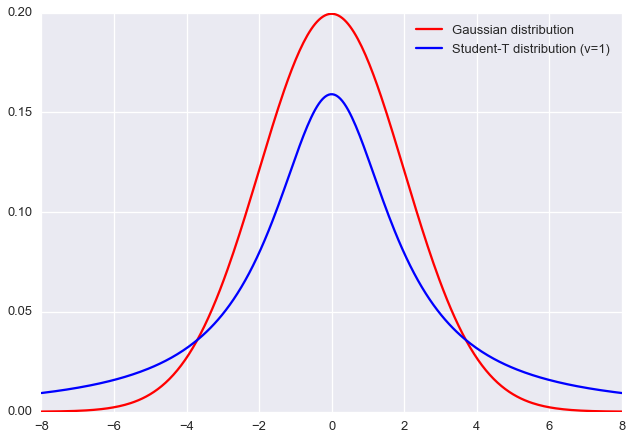

In [5]:
# Example of Gaussian versus Student-T
x_vals = np.linspace(-8, 8, 300)

# PDFs
norm = st.norm.pdf(x_vals, loc=0, scale=2)
stu_t = st.t.pdf(x_vals, df=1, loc=0, scale=2)

# Plot
plt.plot(x_vals, norm, 'r-', label='Gaussian distribution')
plt.plot(x_vals, stu_t, 'b-', label='Student-T distribution (v=1)')
plt.legend(loc='best')

In each test, we have two group of data: regulated and unregulated. We assume that each group is drawn from a Student-T distribution and we're interested in estimating how different the parameters for these two distribution are. We will **assume that the two distributions have the same number of degrees of freedom, $\nu$**.

$$reg_i \sim T(\nu, \mu_1, \sigma_1^2)$$

$$unreg_i \sim T(\nu, \mu_2, \sigma_2^2)$$

The Bayesian approach requires us to specify priors for $\nu$, the $\mu_i$ and the $\sigma_i$. Following [Kruschke (2013)](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf), we will set fairly broad, uninformative priors on these quantities:

$$\mu_1, \mu_2 \sim N \left( \overline {y_i}, 2 \overline {\sigma_i^2} \right)$$

$$\sigma_1, \sigma_2 \sim U (0, 10)$$

$$\nu \sim exp(30)$$

In words, the priors for $\mu_1$ and $\mu_2$ are Gaussian with the means equal to the overall mean of the pooled data and variance that is twice the variance of the pooled data. The prior variances for the Student-T distributions are assumned to be uniform on the interval between 0 and 10, and the prior for $\nu$ is an exponential distribution with mean 30, chosen becasue it allocates credibility fairly evenly over the range between nearly normal and heavy tailed data. The diagram below (from [Kruschke, 2013](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf)) illsutrates this setup.

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


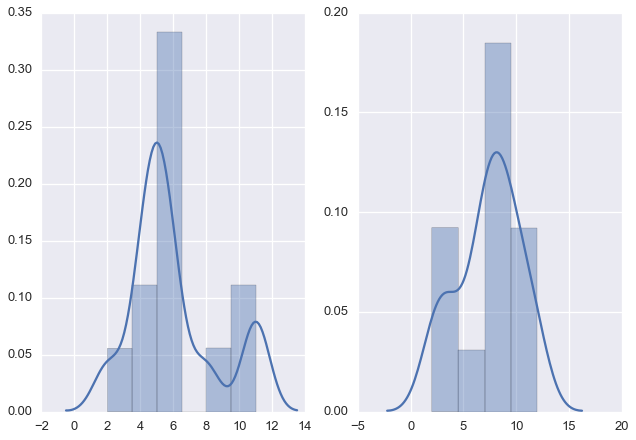

In [3]:
# Columns to consider
pb_cols = ['pb_rich', 'green_rich', 'cyano_abund']

# Get PB data
df = pb_df[pb_cols]

# Join categorical variables to MZB data
df = df.join(site_df[['country', 'regulated']])

# Select country
df = df.query('country == "D"')

# Groups
grpd = df.groupby('regulated')

fig, axes = plt.subplots(nrows=1, ncols=2)

for name, grp in grpd:
    sn.distplot(grp['pb_rich'].values, 
                hist=True,
                kde=True,
                ax=axes[name])

plt.show()

In [4]:
grpd.get_group(0)['pb_rich'].values

array([11,  2,  4, 11,  4,  6,  5,  5,  8,  6,  5,  5], dtype=int64)

In [5]:
reg_data = grpd.get_group(1)['pb_rich'].values
ureg_data = grpd.get_group(0)['pb_rich'].values

u_m = df['pb_rich'].mean()
u_s = df['pb_rich'].std() * 2
sig_low = 1
sig_high = 10

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', u_m, sd=u_s)
    group2_mean = pm.Normal('group2_mean', u_m, sd=u_s)

    group1_std = pm.Uniform('group1_std', lower=sig_low, upper=sig_high)
    group2_std = pm.Uniform('group2_std', lower=sig_low, upper=sig_high)
    
    nu = pm.Exponential('v_minus_one', 1/29.) + 1
    
    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lam1, observed=reg_data)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lam2, observed=ureg_data)

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)



In [6]:
with model:
    trace = pm.sample(2000)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\pymc3\variational\advi.py:195: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  l = (uw.size / 2)
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 416.41it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000002C792470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000002CABE278>], dtype=object)

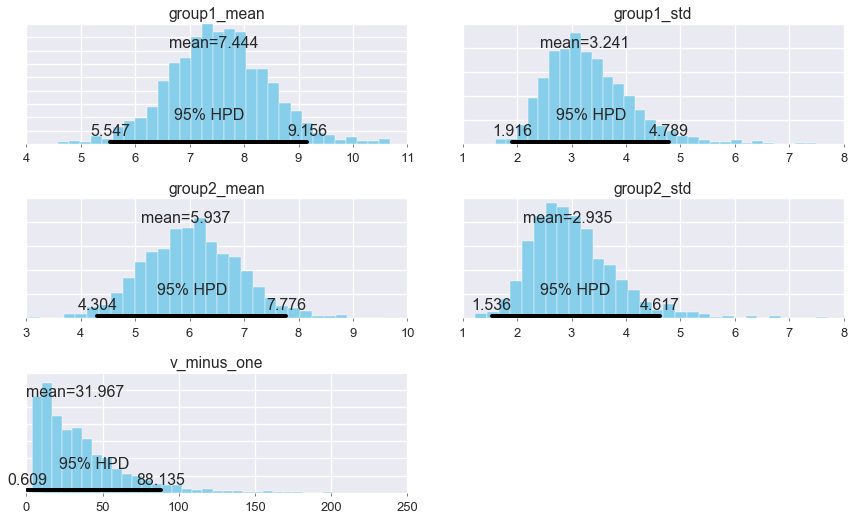

In [7]:
pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'v_minus_one'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000002CF4B208>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000002E415B38>], dtype=object)

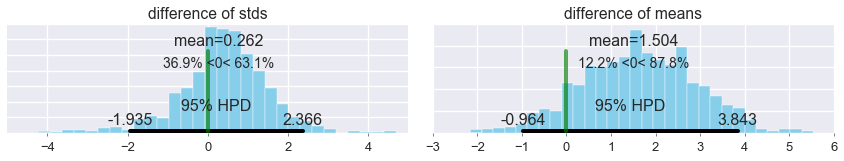

In [8]:
pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds'],
                  ref_val=0,
                  color='#87ceeb')